In [103]:
%config IPCompleter.greedy=True

In [14]:
# pip install bing_image_downloader

  Using cached bing_image_downloader-1.0.4-py3-none-any.whl (5.0 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# pip install keras

In [ ]:
# pip install tensorflow

In [15]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
from keras.preprocessing.image import ImageDataGenerator
from bing_image_downloader import downloader
from keras.models import load_model
from PIL import Image

In [16]:
query_string = ["norwegian male", "norwegian female", "indian male", "indian female"]
output_dir='dataset'

In [17]:
# downloader.download(query_string, 
#                     limit=10000,  
#                     output_dir='dataset', 
#                     adult_filter_off=True, 
#                     force_replace=False, 
#                     timeout=60)

In [18]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             rescale=1./255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

In [92]:
base_dir = pathlib.Path.cwd() / output_dir
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2

In [93]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(base_dir,
                                                               validation_split=VALIDATION_SPLIT,
                                                               subset='training',
                                                               seed=123,
                                                               image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                               batch_size=BATCH_SIZE)

Found 13485 files belonging to 4 classes.
Using 10788 files for training.


In [94]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(base_dir,
                                                              validation_split=VALIDATION_SPLIT,
                                                              subset='validation',
                                                              seed=123,
                                                              image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                              batch_size=BATCH_SIZE)

Found 13485 files belonging to 4 classes.
Using 2697 files for validation.


In [22]:
class_names = train_ds.class_names
print(class_names)

['indian female', 'indian male', 'norwegian female', 'norwegian male']


### Visualizing the dataset

Matplotlib created a temporary config/cache directory at /var/folders/th/4wk9mg4j3674pkjtsrtmfmzh0000gn/T/matplotlib-snxqvey6 because the default path (/Users/shikharanand/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


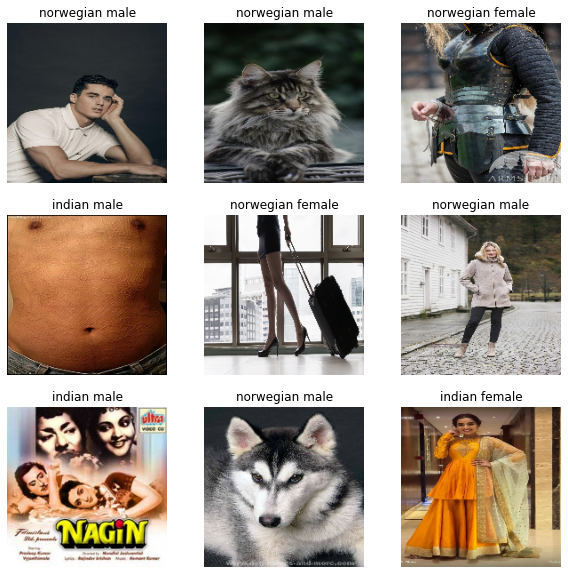

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

You can train a model using these datasets by passing them to model.fit.
If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [24]:
for image_batch, labels_batch in train_ds:
    print(image_batch)
    print(labels_batch)
    print(len(image_batch))
    break

tf.Tensor(
[[[[2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   ...
   [2.50000000e+02 2.50000000e+02 2.50000000e+02]
   [2.50000000e+02 2.50000000e+02 2.50000000e+02]
   [2.50000000e+02 2.50000000e+02 2.50000000e+02]]

  [[2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   ...
   [2.49958328e+02 2.49958328e+02 2.49958328e+02]
   [2.50000000e+02 2.50000000e+02 2.50000000e+02]
   [2.50000000e+02 2.50000000e+02 2.50000000e+02]]

  [[2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   ...
   [2.50000000e+02 2.50000000e+02 2.50000000e+02]
   [2.50000000e+02 2.50000000e+02 2.50000000e+02]
   [2.50000000e+02 2.50000000e+02 2.50000000e+02]]

  ...

  [[3.52055588e+01 3.52055588e+01 3.52055588e+01]
   [3

### Standardize the data

In [25]:
from tensorflow.keras import layers
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [26]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0012253724 0.9749003


### Configure the dataset for performance

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

In [28]:
num_classes = 5

model = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255),
                             layers.Conv2D(32, 3, activation='relu'),
                             layers.MaxPooling2D(),
                             layers.Conv2D(32, 3, activation='relu'),
                             layers.MaxPooling2D(),
                             layers.Conv2D(32, 3, activation='relu'),
                             layers.MaxPooling2D(),
                             layers.Flatten(),
                             layers.Dense(128, activation='relu'),
                             layers.Dense(num_classes)
                            ])

In [29]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
epochs = 1
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=epochs
                   )

169/169 [==============================] - 604s 3s/step - loss: 0.9233 - accuracy: 0.6251 - val_loss: 0.1529 - val_accuracy: 0.9588


In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0

### Visualizing the Training Results

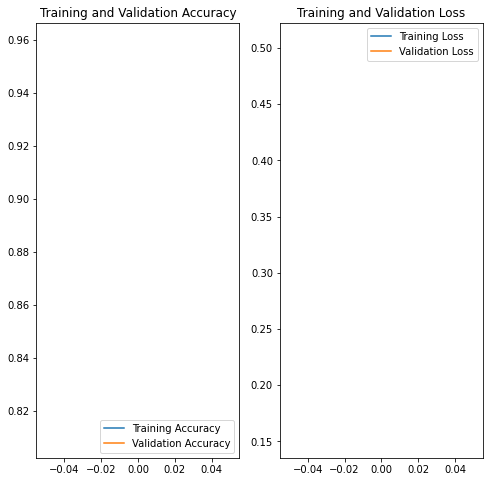

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Test model on unknown dataset

In [51]:
file_name = "test5.jpg"

# set the width and height of the result
width = 224
height = 224
img = Image.open(file_name)

# resize image and reshape
resized_img = img.resize((width,height), Image.ANTIALIAS)
test_image = np.reshape(resized_img, [1, 224, 224, 3])

In [52]:
# predict the test data
predictions = model.predict(test_image)
score = tf.nn.softmax(predictions[0])
class_name = class_names[np.argmax(score)]
print("The image most likely belongs to %s with a %.2f percent confidence." 
      %(class_names[np.argmax(score)], np.max(score)*100)
     )

## Transfer Learning (State of Art Algorithm)

In [66]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

### 1. VGG16

In [65]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [67]:
# add preprocessing layer to the front of VGG
vgg16_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [69]:
# don't train existing weights
for layer in vgg16_model.layers:
    layer.trainable=False

In [73]:
# our layers - you can add more if you want
x = Flatten()(vgg16_model.output)
prediction = Dense(len(class_names), activation='softmax')(x)

In [75]:
# create a modelobject
vgg_model = Model(inputs=vgg16_model.input, outputs=prediction)

In [76]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [104]:
# tell the model what cost and optimization method to use
vgg_model.compile(optimizer='adam',
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [106]:
# fit the model
vgg_model.fit(train_ds,
              validation_data=test_ds,
              epochs=1)

169/169 [==============================] - 4339s 26s/step - loss: 3.6083 - accuracy: 0.9314 - val_loss: 2.1005 - val_accuracy: 0.9592


### Testing the model

In [113]:
file_name = "test3.jpg"

# set the width and height of the result
width = 224
height = 224
img = Image.open(file_name)

# resize image and reshape
resized_img = img.resize((width,height), Image.ANTIALIAS)
test_image = np.reshape(resized_img, [1, 224, 224, 3])

In [114]:
# predict the test data
predictions = vgg_model.predict(test_image)
score = tf.nn.softmax(predictions[0])
class_name = class_names[np.argmax(score)]
print("The image most likely belongs to %s with a %.2f percent confidence." 
      %(class_names[np.argmax(score)], np.max(score)*100)
     )

The image most likely belongs to norwegian female with a 46.11 percent confidence.


### 2. ResNet50

In [117]:
from keras.applications.resnet50 import ResNet50

In [118]:
resnet50_model = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 22s 0us/step


In [120]:
# don't train existing weights
for layer in resnet50_model.layers:
    layer.trainable=False

In [121]:
# our layers - you can add more if you want
x = Flatten()(resnet50_model.output)
prediction = Dense(len(class_names), activation='softmax')(x)

In [122]:
# create a modelobject
resnet_model = Model(inputs=resnet50_model.input, outputs=prediction)

In [124]:
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [135]:
# tell the model what cost and optimization method to use
resnet_model.compile(optimizer='adam',
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])


In [126]:
# fit the model
resnet_model.fit(train_ds,
              validation_data=test_ds,
              epochs=1)

 12/169 [=>............................] - ETA: 22:07 - loss: 7.6876 - accuracy: 0.5072

KeyboardInterrupt: 

### Testing the model

In [113]:
file_name = "test3.jpg"

# set the width and height of the result
width = 224
height = 224
img = Image.open(file_name)

# resize image and reshape
resized_img = img.resize((width,height), Image.ANTIALIAS)
test_image = np.reshape(resized_img, [1, 224, 224, 3])

In [114]:
# predict the test data
predictions = resnet_model.predict(test_image)
score = tf.nn.softmax(predictions[0])
class_name = class_names[np.argmax(score)]
print("The image most likely belongs to %s with a %.2f percent confidence." 
      %(class_names[np.argmax(score)], np.max(score)*100)
     )

The image most likely belongs to norwegian female with a 46.11 percent confidence.


### 3. InceptionV3

In [128]:
from keras.applications.inception_v3 import InceptionV3

In [129]:
inceptionV3_model = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 143s 2us/step


In [130]:
# don't train existing weights
for layer in inceptionV3_model.layers:
    layer.trainable=False

In [131]:
# our layers - you can add more if you want
x = Flatten()(inceptionV3_model.output)
prediction = Dense(len(class_names), activation='softmax')(x)

In [133]:
# create a modelobject
inception_model = Model(inputs=inceptionV3_model.input, outputs=prediction)

In [134]:
inception_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [136]:
# tell the model what cost and optimization method to use
inception_model.compile(optimizer='adam',
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])


In [137]:
# fit the model
inception_model.fit(train_ds,
              validation_data=test_ds,
              epochs=1)

 66/169 [==========>...................] - ETA: 10:06 - loss: 178.8194 - accuracy: 0.4588

KeyboardInterrupt: 

### Testing the model

In [113]:
file_name = "test3.jpg"

# set the width and height of the result
width = 224
height = 224
img = Image.open(file_name)

# resize image and reshape
resized_img = img.resize((width,height), Image.ANTIALIAS)
test_image = np.reshape(resized_img, [1, 224, 224, 3])

In [114]:
# predict the test data
predictions = inception_model.predict(test_image)
score = tf.nn.softmax(predictions[0])
class_name = class_names[np.argmax(score)]
print("The image most likely belongs to %s with a %.2f percent confidence." 
      %(class_names[np.argmax(score)], np.max(score)*100)
     )

The image most likely belongs to norwegian female with a 46.11 percent confidence.


### 4. Xception

In [139]:
from keras.applications.xception import Xception

In [140]:
xception = Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

83689472/83683744 [==============================] - 3s 0us/step


In [141]:
# don't train existing weights
for layer in xception.layers:
    layer.trainable=False

In [143]:
# our layers - you can add more if you want
x = Flatten()(xception.output)
prediction = Dense(len(class_names), activation='softmax')(x)

In [144]:
# create a modelobject
xception_model = Model(inputs=xception.input, outputs=prediction)

In [145]:
xception_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [146]:
# tell the model what cost and optimization method to use
xception_model.compile(optimizer='adam',
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])


In [147]:
# fit the model
xception_model.fit(train_ds,
              validation_data=test_ds,
              epochs=1)

 70/169 [===========>..................] - ETA: 58:52 - loss: 45.6229 - accuracy: 0.5639

KeyboardInterrupt: 

### Testing the model

In [ ]:
file_name = "test3.jpg"

# set the width and height of the result
width = 224
height = 224
img = Image.open(file_name)

# resize image and reshape
resized_img = img.resize((width,height), Image.ANTIALIAS)
test_image = np.reshape(resized_img, [1, 224, 224, 3])

In [ ]:
# predict the test data
predictions = xception_model.predict(test_image)
score = tf.nn.softmax(predictions[0])
class_name = class_names[np.argmax(score)]
print("The image most likely belongs to %s with a %.2f percent confidence." 
      %(class_names[np.argmax(score)], np.max(score)*100)
     )